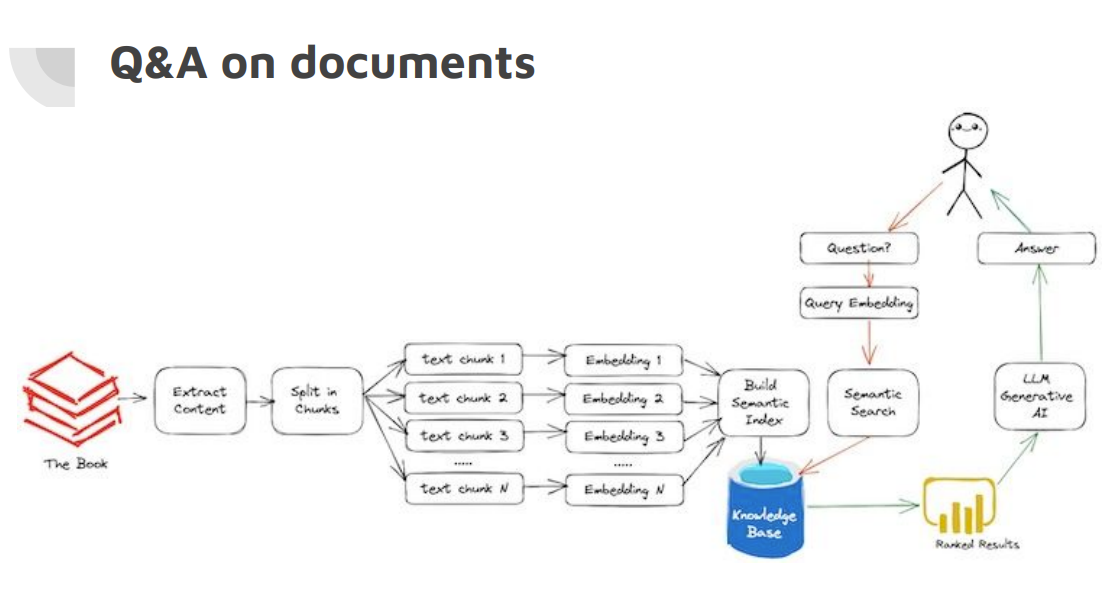

In [ ]:
!pip install langchain
!pip install cohere
!pip install chromadb
!pip install pypdf
!pip install datasets
!pip install SpeechRecognition

In [100]:
import os
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.embeddings import CohereEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import Cohere
from langchain.chains import RetrievalQA
from langchain import PromptTemplate

In [101]:
file_path= "/content/state_of_the_union.txt"
loader = TextLoader(file_path)

In [102]:
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0) #Splitting the text and creating chunks
docs = text_splitter.split_documents(documents)
embeddings = CohereEmbeddings(cohere_api_key="4aJ9yWbIrOzI2W5LZeLeIdin2AYMpkq18PffLuvi") #Creating Cohere Embeddings

In [108]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
persist_directory = 'db'
vectordb = Chroma.from_documents(documents=docs,
                                 embedding=embeddings,
                                 persist_directory=persist_directory)

In [109]:
#Using similarity search- Extractive QA
#2.1
query = "What did the president say about Ketanji Brown Jackson"
#2.2
docs = vectordb.similarity_search(query) #Searching for the query in the Vector Database and using cosine similarity for the same.
#Cosine Similarity- https://www.machinelearningplus.com/nlp/cosine-similarity/

In [110]:
print(docs[0].page_content)

Tonight. I call on the Senate to: Pass the Freedom to Vote Act. Pass the John Lewis Voting Rights Act. And while you’re at it, pass the Disclose Act so Americans can know who is funding our elections. 

Tonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. 

One of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. 

And I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.


In [111]:
# persiste the db to disk
vectordb.persist()
vectordb = None

In [112]:
# Now we can load the persisted database from disk, and use it as normal.
vectordb = Chroma(persist_directory=persist_directory,
                  embedding_function=embeddings)

In [113]:
retriever = vectordb.as_retriever()

In [114]:
docs = retriever.get_relevant_documents("What did the president say about Ketanji Brown Jackson?")

In [115]:
docs

[Document(page_content='Tonight. I call on the Senate to: Pass the Freedom to Vote Act. Pass the John Lewis Voting Rights Act. And while you’re at it, pass the Disclose Act so Americans can know who is funding our elections. \n\nTonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. \n\nOne of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. \n\nAnd I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.', metadata={'source': '/content/state_of_the_union.txt'}),
 Document(page_content='Tonight. I call on the Senate to: Pass the Freedom to Vote Act. Pass the John Lewis Voting Rights A

In [116]:
qa_chain = RetrievalQA.from_chain_type(llm=Cohere(cohere_api_key="4aJ9yWbIrOzI2W5LZeLeIdin2AYMpkq18PffLuvi"),
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True,
                                )

In [117]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:


In [121]:
template = """
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.Use only the document for your answer and you may summarize the answer to make it look better.

{context}

Question: {question}
"""

In [122]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=Cohere(cohere_api_key="4aJ9yWbIrOzI2W5LZeLeIdin2AYMpkq18PffLuvi"),
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True,
                                  chain_type_kwargs={
                                  "prompt": PromptTemplate(
                                  template=template,
                                  input_variables=["context", "question"],)})


In [123]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template) #This is the prompt behind the chain.


Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.Use only the document for your answer and you may summarize the answer to make it look better. 

{context}

Question: {question}



In [124]:
# full example
query = "What did the president say about Ketanji Brown Jackson?" #part  of the prompt.
llm_response = qa_chain(query)

In [125]:
llm_response

{'query': 'What did the president say about Ketanji Brown Jackson?',
 'result': "The president said that Ketanji Brown Jackson is one of the nation's top legal minds who will continue Justice Breyer's legacy of excellence.",
 'source_documents': [Document(page_content='Tonight. I call on the Senate to: Pass the Freedom to Vote Act. Pass the John Lewis Voting Rights Act. And while you’re at it, pass the Disclose Act so Americans can know who is funding our elections. \n\nTonight, I’d like to honor someone who has dedicated his life to serve this country: Justice Stephen Breyer—an Army veteran, Constitutional scholar, and retiring Justice of the United States Supreme Court. Justice Breyer, thank you for your service. \n\nOne of the most serious constitutional responsibilities a President has is nominating someone to serve on the United States Supreme Court. \n\nAnd I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal 

In [126]:
print(llm_response["result"])

The president said that Ketanji Brown Jackson is one of the nation's top legal minds who will continue Justice Breyer's legacy of excellence.


Deleting the DB and reloading it

In [127]:
!zip -r db.zip ./db

updating: db/ (stored 0%)
updating: db/chroma-embeddings.parquet (deflated 19%)
updating: db/chroma-collections.parquet (deflated 50%)
updating: db/index/ (stored 0%)
updating: db/index/id_to_uuid_f7815445-83a1-40d0-8dac-18a12691e2a4.pkl (deflated 33%)
updating: db/index/uuid_to_id_f7815445-83a1-40d0-8dac-18a12691e2a4.pkl (deflated 39%)
updating: db/index/index_f7815445-83a1-40d0-8dac-18a12691e2a4.bin (deflated 43%)
updating: db/index/index_metadata_f7815445-83a1-40d0-8dac-18a12691e2a4.pkl (deflated 15%)


In [128]:
# To cleanup, you can delete the collection
vectordb.delete_collection()
vectordb.persist()

# delete the directory
!rm -rf db/

In [129]:
!unzip db.zip

Archive:  db.zip
   creating: db/
  inflating: db/chroma-embeddings.parquet  
  inflating: db/chroma-collections.parquet  
   creating: db/index/
  inflating: db/index/id_to_uuid_f7815445-83a1-40d0-8dac-18a12691e2a4.pkl  
  inflating: db/index/uuid_to_id_f7815445-83a1-40d0-8dac-18a12691e2a4.pkl  
  inflating: db/index/index_f7815445-83a1-40d0-8dac-18a12691e2a4.bin  
  inflating: db/index/index_metadata_f7815445-83a1-40d0-8dac-18a12691e2a4.pkl  


In [141]:
persist_directory = 'db'
embedding = CohereEmbeddings(cohere_api_key="4aJ9yWbIrOzI2W5LZeLeIdin2AYMpkq18PffLuvi")

vectordb2 = Chroma(persist_directory=persist_directory,
                  embedding_function=embedding,
                   )

In [142]:
template = """
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.Use only the document for your answer and you may summarize the answer to make it look better.

{context}

Question: {question}
"""

In [144]:
qa_chain = RetrievalQA.from_chain_type(llm=Cohere(cohere_api_key="4aJ9yWbIrOzI2W5LZeLeIdin2AYMpkq18PffLuvi"),
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True,
                                  chain_type_kwargs={
                                  "prompt": PromptTemplate(
                                  template=template,
                                  input_variables=["context", "question"],)})

In [145]:
query = "What did the president say about Ketanji Brown Jackson "
llm_response = qa_chain(query)

In [146]:
llm_response

{'query': 'What did the president say about Ketanji Brown Jackson ',
 'result': '\nThe president said that he was very happy that Ketanji Brown Jackson was confirmed to the Supreme Court and that he was very proud of her.',
 'source_documents': []}

In [147]:
llm_response["result"]

'\nThe president said that he was very happy that Ketanji Brown Jackson was confirmed to the Supreme Court and that he was very proud of her.'